In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Representation space. samples: 273


<Figure size 1584x432 with 0 Axes>

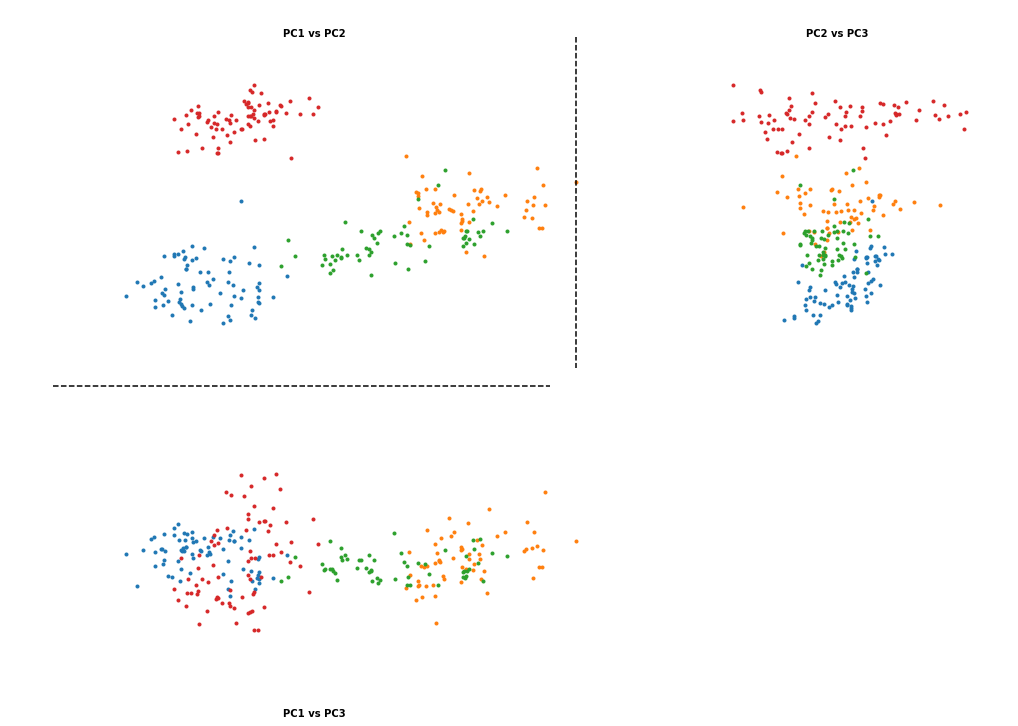

In [2]:
from dataVisualization import *
from imageUtils import *
from clusterTools import *
from removePetiole import *
from processContour import *
from clusterResults import *
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

%matplotlib inline

### data source
path_data  = '/home/jorge/data/leaf_image/ImageCLEF2012/data/select_experim/'
data_file  = '../notebooks/species.xlsx' # input data file of species specifications

### sampling process
lst_species   = ['elliptic', 'oblong', 'obovate', 'ovate']
#lst_species = ['apexAcuminate', 'apexComplex', 'apexConvex', 'apexRetuse', 'apexRounded', 'apexStraight']
df = load_data(path_data, lst_species)

sz_contour  = 640
h           = 12
min_ngroups = 8
prefix      = 'results_experm/tesis/laminar_'

num_leaves  = len(df.index)
num_species = len(lst_species)
contours    = np.zeros((num_leaves, sz_contour+1, 2))   # Concatenate contours
features    = np.zeros((num_leaves, h), dtype=complex)
signals     = []

fig = plt.figure(figsize=(22,6))
for i in range(num_leaves):
    imb = binImage(df.file[i])
    im1 = verticalStraighten(imb) 
    outl = getContour(im1)
    marks = removePetiole(im1)  
    imbody = im1[marks[2]:marks[1], :]
    imbody = bigPatchImage(imbody)
    y1, perf, r1, r2 = bodyAnalysis(imbody)
    
    outline = getContour(imbody)
    contour = interparc(sz_contour+1, outline)
    contours[i] = contour
    x   = contour[:,0] + contour[:,1]*1j
    dx  = np.diff(x, axis=0); 
    ndx = np.divide(dx, np.absolute(dx))
    ndk = np.fft.fft(ndx.T)
    ndk = ndk.T
    ind_harm = list(range(h//2)) + list(range(sz_contour-h//2,sz_contour))
    features[i] = ndk[ind_harm]
    
mfeat    = np.absolute(features)
#mfeat    = (mfeat - mfeat.mean(axis=0))/mfeat.std(axis=0)
pca      = PCA(n_components=5)
pca.fit(mfeat)
    
points   = pca.transform(mfeat)
points   = points / points.max()
weights  = np.cumsum(pca.explained_variance_ratio_)*100

dist     = pdist(points[:,0:3])
ndx_dist = np.argsort(dist)

arad     = alpha_radius_kde(points[:,0:3], 'exponential', 0.5)
adist    = get_alpha_dist(dist, arad)
J        = np.argsort(adist)
dTri     = Delaunay(points[:,0:3])

draw_points(points, df.cat, save=prefix+'pts.svg')

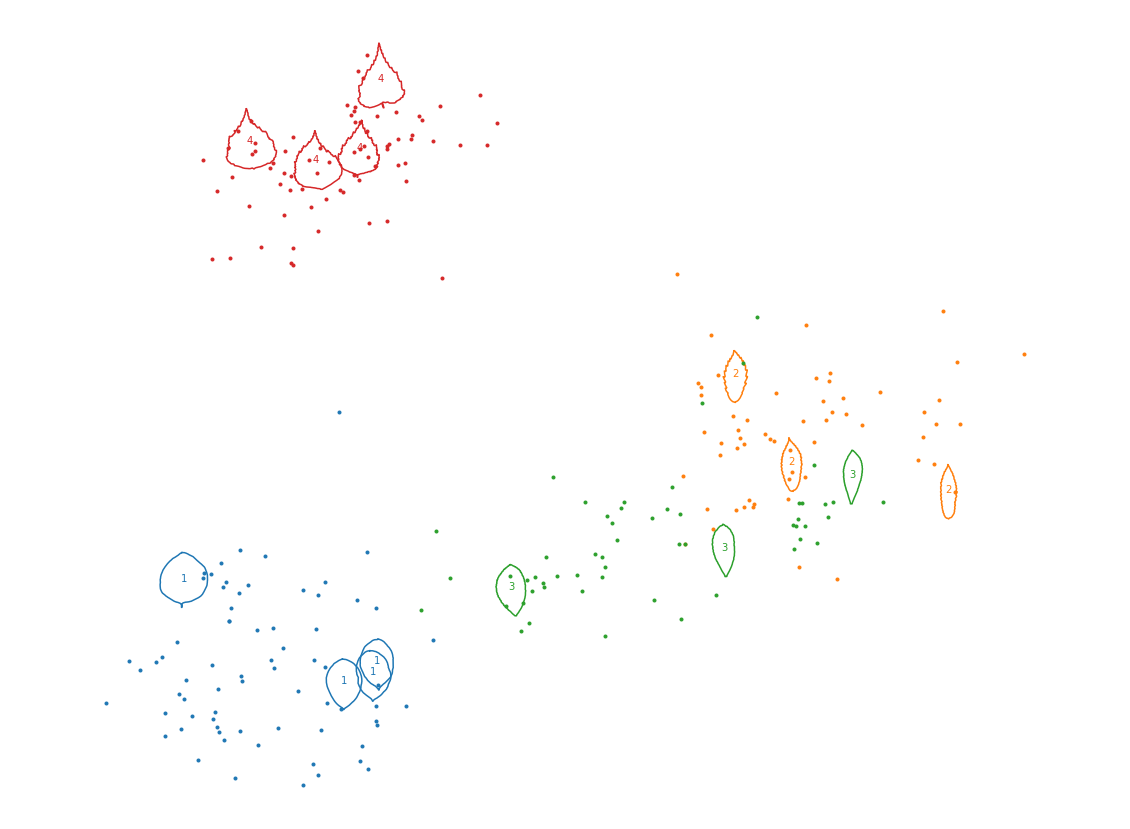

In [3]:
draw_ptsContoursInfo(points, contours, df, d1=0, d2=1, sc=0.05)

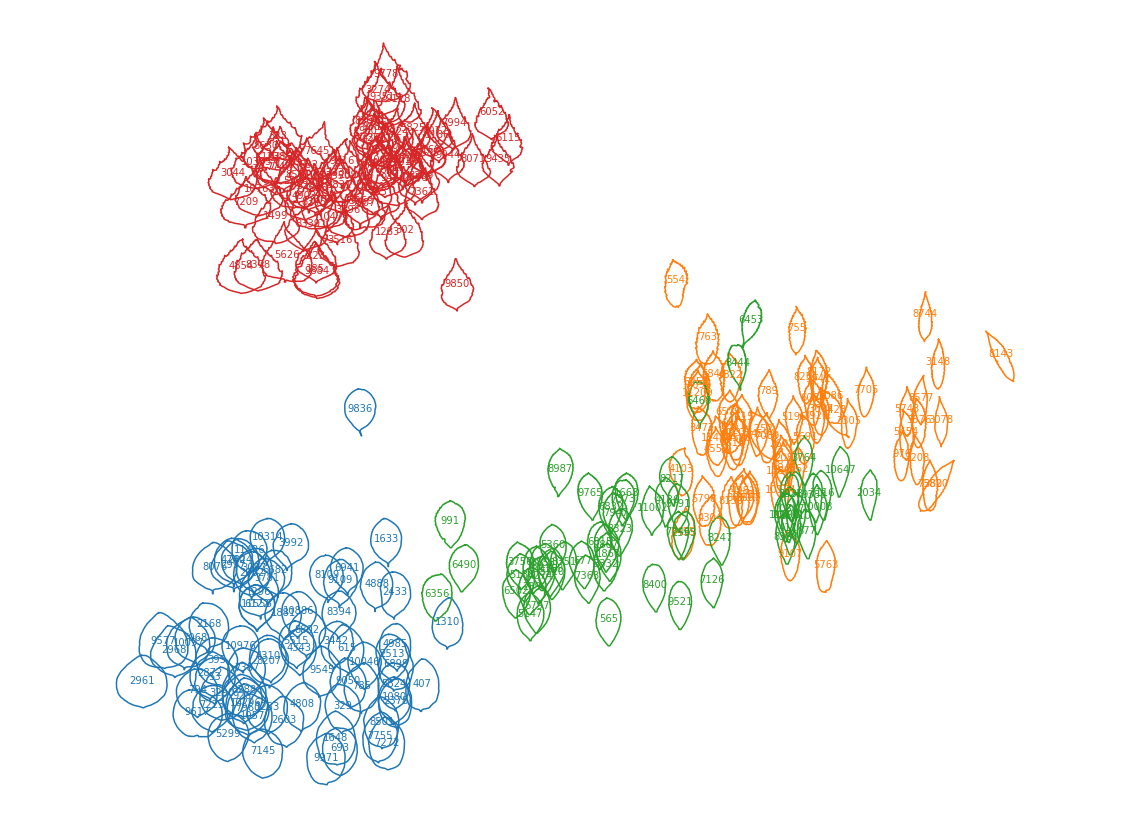

Leaves distribution in the representation space. Projection each leaf samples in the representation space


In [4]:
draw_ptsContours(points, contours, df, save=prefix+'contours.svg', d1=0, d2=1, sc=0.05)

In [5]:
dEdge = generate_edges(dTri, num_leaves)
print(datetime.datetime.now())
tinit = time.time()
data = meanshift_results2(J, num_leaves, dEdge, Q=8)
tfin = time.time()
resultsTDA = resultsTDA[:data[3],:]
print('Termino, segundos', tfin-tinit)

dfr = pd.DataFrame(resultsTDA, columns=['k', 'event', 'gr1', 'gr2'])
dfr['rend'] = adist[J[dfr.k]]*10
dfr['i_'] = dfr['k'].apply(lambda x: get_index(J[x], num_leaves)[0])
dfr['j_'] = dfr['k'].apply(lambda x: get_index(J[x], num_leaves)[1])

2022-12-13 16:11:12.054863
0 	 [ 1  0  0 -1]
100 	 [105   1  38  -1]
200 	 [228   1  41  -1]
300 	 [388   3  33  50]
400 	 [685   5   5 124]
Final it = 482 k = 37128
Termino, segundos 40.85519814491272


In [6]:
pH1 = np.array(persistArrayH1)
pH2 = np.array(persistArrayH2)
persistencePlot(adist[J[pH1[:,0]]], pH1[:,1], adist[J[pH2[:,0]]], pH2[:,1], save=prefix+'linePersist.svg')
groupsPersistPlot(adist[J[pH1[:,0]]], pH1[:,1].astype(int), adist[J[pH2[:,0]]], pH2[:,1].astype(int), save=prefix+'barPersist.svg')

In [7]:
dfr[(dfr.rend>0.71) & (dfr.rend<0.73)]

k  event  gr1  gr2      rend   i_   j_
470  2048      5    1  165  0.718706  100  119
471  2055      5    1  194  0.719688  164  167
472  2055      5    1   12  0.719688  164  167

In [8]:
u, f = np.unique(df.cat, return_counts=True)
for i in u: print(lst_species[i], '   \t', f[i])
print('--'*40)
H2 = groupsH2(dfr, num_leaves, 470)
evaluation(H2, df.cat, lst_species)

elliptic    	 75
oblong    	 62
obovate    	 58
ovate    	 78
--------------------------------------------------------------------------------
FINAL F1 SCORE : 0.7765567765567766
---------------------------------------------------------------------------------------------------- 
CONFUSION MATRIX:


species   2   1  273   0  Total
0  elliptic  72   0    3   0     75
1    oblong   0  60    2   0     62
2   obovate   1  54    3   0     58
3     ovate   0   0    1  77     78

species   2   1  273   0  Total
0  elliptic  72   0    3   0     75
1    oblong   0  60    2   0     62
2   obovate   1  54    3   0     58
3     ovate   0   0    1  77     78

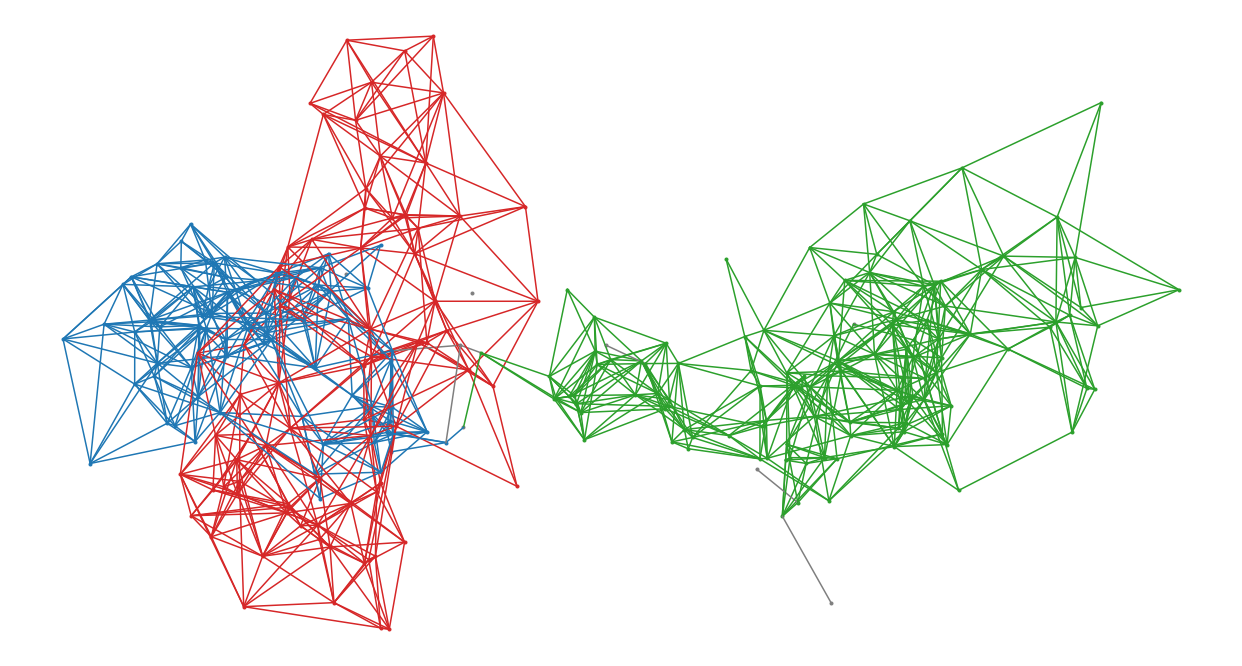

In [9]:
u, ndx = np.unique(H2, return_index=True)
ind = np.argsort(ndx)
arn = np.arange(u.size)
arn[u[ind]==num_leaves] = 23
pred = interchange(np.array(H2), u[ind], arn) 
draw_points1d(points, pred, J, num_leaves, dEdge, 2048, d1=0, d2=2, save=prefix+'pred.svg')

In [10]:
sw_disag = False #en adelante para ejecutar la des-agregación de elementos por grupo una sola vez
dfx, sam = life_groupsH2(dfr, num_leaves)
dfx.sort_values(['duration', 'group'], ascending=[False,True])

group     birth      dead  qleaves  fusion  duration
9       0  0.227809  1.316494      272       0  1.088685
6       1  0.227809  1.316494      194       0  1.088685
0       2  0.227809  0.719688       73       1  0.491879
3       5  0.288309  0.570862       80       1  0.282554
2       4  0.282822  0.486455       29       0  0.203633
8      16  0.350159  0.522155       16       2  0.171996
12     11  0.406466  0.557596        8       5  0.151130
11     18  0.389329  0.482016       11       5  0.092687
4       3  0.278614  0.364220       28       2  0.085606
10      8  0.316768  0.361164       13       1  0.044396
13     15  0.418056  0.459728       10       4  0.041672
5      13  0.316768  0.358266        9       8  0.041498
1      12  0.278614  0.314742       11       3  0.036128
7       9  0.334204  0.357298        9       0  0.023094

In [11]:
nleaves, sw_disag = disagregate_leaves(dfx, sam, 8, sw_disag)
dfx['qleaves'] = nleaves
dfx.sort_values('duration', ascending=False)

group     birth      dead  qleaves  fusion  duration
6       1  0.227809  1.316494       41       0  1.088685
9       0  0.227809  1.316494       49       0  1.088685
0       2  0.227809  0.719688       57       1  0.491879
3       5  0.288309  0.570862       61       1  0.282554
2       4  0.282822  0.486455       29       0  0.203633
8      16  0.350159  0.522155       16       2  0.171996
12     11  0.406466  0.557596        8       5  0.151130
11     18  0.389329  0.482016       11       5  0.092687
4       3  0.278614  0.364220       28       2  0.085606
10      8  0.316768  0.361164       13       1  0.044396
13     15  0.418056  0.459728       10       4  0.041672
5      13  0.316768  0.358266        9       8  0.041498
1      12  0.278614  0.314742       11       3  0.036128
7       9  0.334204  0.357298        9       0  0.023094

/home/jorge/Dropbox/proyectos/leaf_shape_discovery/devel/clusterResults.py:148: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



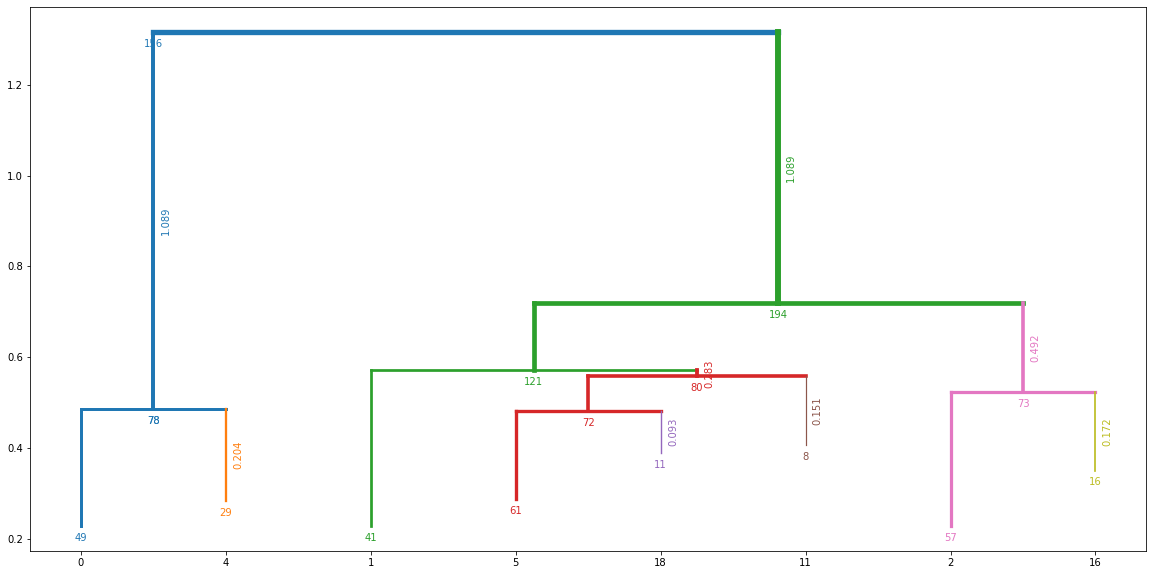

In [12]:
bars = draw_treeCluster(dfx, num_regs=8, save=prefix+'tree.svg')

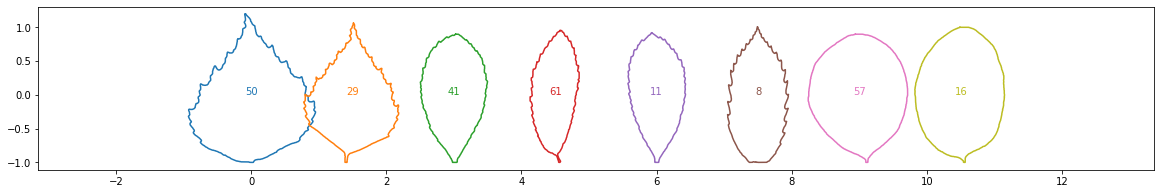

In [13]:
draw_tree_leaf(points, contours, bars, sam, save=prefix+'leaves.svg')

Text(0.5, 1.0, 'Method: ward')

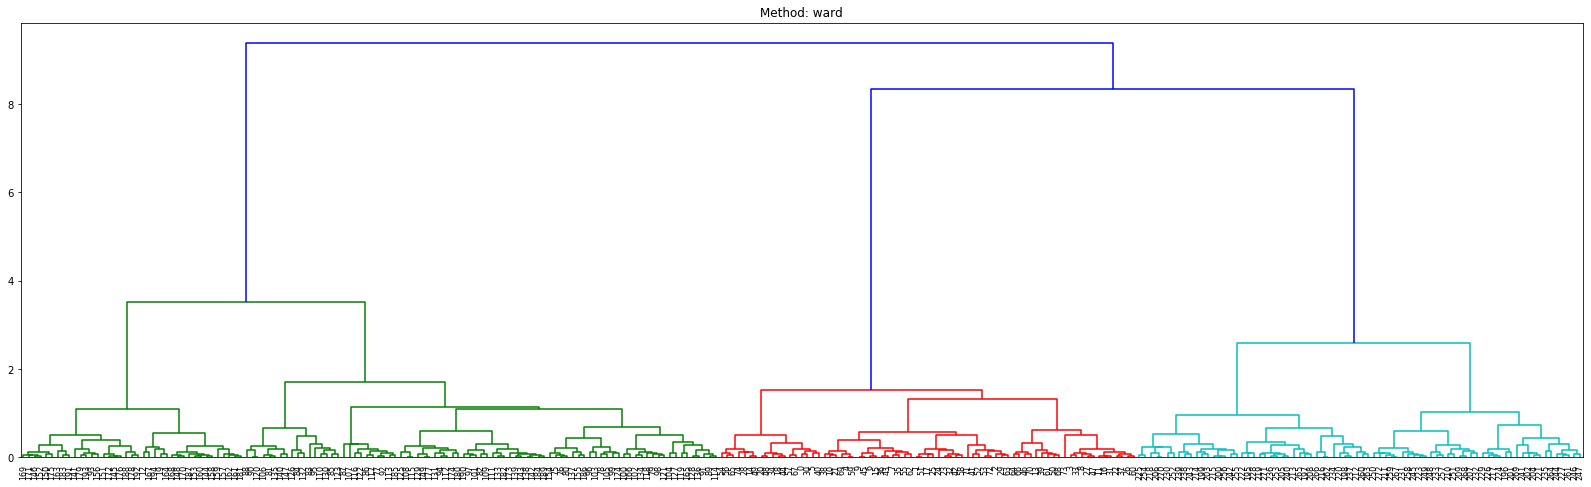

In [14]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
 
dfd = pd.DataFrame(points[:,0:3], columns=['x', 'y', 'z'])
fig = plt.figure(figsize=(28, 8))
Zx = linkage(dfd, 'ward')
dendrogram(Zx, leaf_font_size=8, labels=dfd.index)
plt.title('Method: ward')

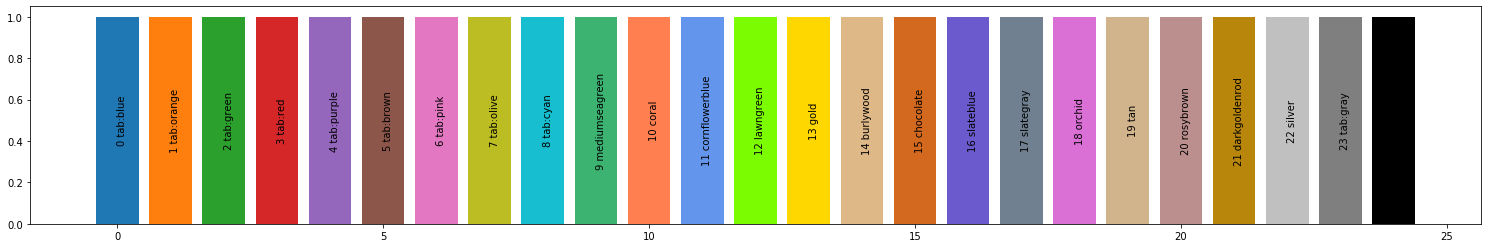

In [15]:
xx = list(range(25))
yy = [1]*len(xx)
fig = plt.figure(figsize=(26,4))
for i in range(len(yy)):
    plt.bar(xx[i],yy[i], color=palette[i])
    plt.text(i, 0.5, str(i)+' '+palette[i], va='center', rotation='vertical')